## Using feature weights to see how counterfactuals affect models

In [1]:
DATAPATH = "../data/"

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
%matplotlib inline

font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

runs = 5

In [4]:
from joblib import dump, load
from bert_sklearn import load_model

In [5]:
constructs = ['sentiment',
              'sexism',
              'hatespeech'
             ]
models = ['logreg',
         # 'bert',
         ]
modes = [True, False]
test_sets = {"sentiment" : [
                            "original",
                            "kaggle",
                            ],
             "sexism": [
                             "original",
                             "exist",
                       ],
             "hatespeech" : [
                             "original",
                            "hateval"]
            }

adv_test_sets = ['adv_inv', 'adv_swap']

labels = {'sentiment' : {'positive': 1, 'negative' : 0},
          'sexism' : {'sexist' : 1, 'non-sexist' : 0},
          'hatespeech' : {'hate' : 1, 'not hate' : 0}
                          }

In [6]:
classifiers = {}

for construct in constructs:
    if construct not in classifiers:
        classifiers[construct] = {}
    for model in models:
        if model not in classifiers[construct]:
            classifiers[construct][model] = {}
        for mode in modes:
            if mode not in classifiers[construct][model]:
                classifiers[construct][model][mode] = []
            for run in range(runs):
                if model == 'bert':
                    classifiers[construct][model][mode].append(load_model('../ml_models/%s_%s_%s_%d.joblib' %(construct,
                                                                                                      model,
                                                                                                      mode,
                                                                                                      run))) 
                else:
                    classifiers[construct][model][mode].append(load('../../../sexism/sexist_code/explanations/ml_models/%s_%s_%s_%d.joblib' %(construct,
                                                                                            model,
                                                                                            mode,
                                                                                            run)))
            

In [7]:
len(classifiers['sentiment']['logreg'][True][0].named_steps['clf'].coef_.ravel())

16282

### Global Explanations

In [8]:
def visualize_coefficients(classifier, feature_names, n_top_features=10):
    # see http://github.com/amueller/mglearn/blob/cbae37d906261dad173cbc6696dcef69dfd0cbaf/mglearn/tools.py
    # and http://github.com/amueller/scipy-2018-sklearn
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    #fig = plt.figure(figsize=(15, 5))
#     colors = ["orange" if c < 0 else "blue" for c in coef[interesting_coefficients]]
#     labels = ["non-sexist" if c < 0 else "sexist" for c in coef[interesting_coefficients]]
#     ax.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    
#     ax.set_xticks(np.arange(1, 2 * n_top_features + 1))
#     ax.set_xticklabels(feature_names[interesting_coefficients], rotation=60, ha="right")
#     ax.set_title("Feature importances")
#     ax.legend()
    
    feature_names = np.array(feature_names)
    data = pd.DataFrame({"pos feature": feature_names[positive_coefficients],
                        "pos coef": coef[positive_coefficients],
                        "neg feature": feature_names[negative_coefficients],
                        "neg coeff" :  coef[negative_coefficients],
                        })
    return data



In [9]:
data = {}

for construct in constructs:
    estimators = classifiers[construct]['logreg']

    estimator = estimators[True][0]
    feat_true = visualize_coefficients(estimator.named_steps['clf'],
                           estimator.named_steps['tfidf'].get_feature_names(),
                           n_top_features=20)
    
    estimator = estimators[False][0]
    feat_false = visualize_coefficients(estimator.named_steps['clf'],
                           estimator.named_steps['tfidf'].get_feature_names(),
                           n_top_features=20)
    print(construct)
    data[construct] = pd.concat([feat_true, feat_false], names = ['counterfactual', 'non-counterfactual'], axis = 1)
    
    
print(data['sentiment'].round(2).to_latex())

sentiment
sexism
hatespeech
\begin{tabular}{llrlrlrlr}
\toprule
{} &  pos feature &  pos coef & neg feature &  neg coeff & pos feature &  pos coef & neg feature &  neg coeff \\
\midrule
0  &       better &      0.20 &         bad &      -0.90 &    favorite &      0.93 &         bad &      -3.59 \\
1  &   incredible &      0.20 &       worst &      -0.83 &     romance &      0.97 &      horror &      -2.44 \\
2  &        loved &      0.21 &    terrible &      -0.77 &      highly &      0.98 &       worst &      -2.32 \\
3  &     terrific &      0.21 &      boring &      -0.71 &     classic &      0.98 &       waste &      -1.94 \\
4  &           10 &      0.23 &         not &      -0.65 &       loved &      1.00 &    terrible &      -1.83 \\
5  &    brilliant &      0.24 &       awful &      -0.50 &       young &      1.02 &       awful &      -1.82 \\
6  &        still &      0.25 &    horrible &      -0.50 &   beautiful &      1.06 &      boring &      -1.79 \\
7  &    fantastic &    

In [10]:
data['sentiment']

,pos feature,pos coef,neg feature,neg coeff,pos feature,pos coef,neg feature,neg coeff
0,better,0.195745,bad,-0.895763,favorite,0.926987,bad,-3.590381
1,incredible,0.203925,worst,-0.828576,romance,0.970660,horror,-2.437748
2,loved,0.205788,terrible,-0.767189,highly,0.980479,worst,-2.320138
3,terrific,0.209736,boring,-0.710398,classic,0.984783,waste,-1.936489
4,10,0.232053,not,-0.648473,loved,1.001678,terrible,-1.833942
5,brilliant,0.242483,awful,-0.504250,young,1.023265,awful,-1.819437
6,still,0.247512,horrible,-0.498226,beautiful,1.059979,boring,-1.790292
7,fantastic,0.257683,nothing,-0.389233,family,1.077179,poor,-1.570686
8,awesome,0.281169,worse,-0.359969,especially,1.140207,even,-1.535729
9,love,0.287462,stupid,-0.348752,enjoyed,1.161978,nothing,-1.524019


In [11]:
data['sexism']

,pos feature,pos coef,neg feature,neg coeff,pos feature,pos coef,neg feature,neg coeff
0,clean,1.080548,people,-3.258739,in,1.478970,love,-2.284136
1,football,1.136539,love,-2.717172,lady,1.497190,people,-1.966650
2,womens,1.149031,person,-2.076089,me,1.623623,as,-1.780841
3,family,1.315903,adults,-1.881332,shouldn,1.684533,these,-1.629620
4,sex,1.333635,kids,-1.793781,than,1.747371,this,-1.621159
5,work,1.384578,grownups,-1.594879,don,1.790280,that,-1.611349
6,guys,1.612796,kid,-1.552756,sexist,1.905523,kat,-1.498882
7,lady,1.850647,adult,-1.551183,when,2.097087,same,-1.497961
8,wife,1.868115,without,-1.436470,girl,2.135900,without,-1.376817
9,husband,1.872325,grownup,-1.407079,sports,2.168650,you,-1.303217


In [12]:
print(data['sexism'].round(2).to_latex())

\begin{tabular}{llrlrlrlr}
\toprule
{} & pos feature &  pos coef & neg feature &  neg coeff & pos feature &  pos coef & neg feature &  neg coeff \\
\midrule
0  &       clean &      1.08 &      people &      -3.26 &          in &      1.48 &        love &      -2.28 \\
1  &    football &      1.14 &        love &      -2.72 &        lady &      1.50 &      people &      -1.97 \\
2  &      womens &      1.15 &      person &      -2.08 &          me &      1.62 &          as &      -1.78 \\
3  &      family &      1.32 &      adults &      -1.88 &     shouldn &      1.68 &       these &      -1.63 \\
4  &         sex &      1.33 &        kids &      -1.79 &        than &      1.75 &        this &      -1.62 \\
5  &        work &      1.38 &    grownups &      -1.59 &         don &      1.79 &        that &      -1.61 \\
6  &        guys &      1.61 &         kid &      -1.55 &      sexist &      1.91 &         kat &      -1.50 \\
7  &        lady &      1.85 &       adult &      -1.55 &  

In [13]:
data['hatespeech']

,pos feature,pos coef,neg feature,neg coeff,pos feature,pos coef,neg feature,neg coeff
0,black,2.112472,racists,-3.008505,jews,2.694801,fucking,-9.868505
1,brownies,2.122562,covid,-1.912285,nice,2.760182,lot,-5.408464
2,fags,2.126391,cars,-1.809505,wrong,2.805553,fuck,-5.050419
3,jews,2.165836,food,-1.804504,urgh,2.814722,neighbour,-4.632906
4,white,2.243532,haters,-1.580376,concepts,2.948465,know,-4.259160
5,retarded,2.251389,cats,-1.538932,already,2.979320,sucks,-4.232420
6,whores,2.329988,idiot,-1.508845,think,2.990962,call,-4.180826
7,niggers,2.359681,dogs,-1.479528,idea,3.027343,bitch,-4.148601
8,trannies,2.369208,corona,-1.477884,happy,3.089704,many,-3.695405
9,immigrants,2.382629,capitalism,-1.430739,let,3.529371,friend,-3.637709


In [14]:
print(data['hatespeech'].round(2).to_latex())

\begin{tabular}{llrlrlrlr}
\toprule
{} & pos feature &  pos coef &   neg feature &  neg coeff & pos feature &  pos coef & neg feature &  neg coeff \\
\midrule
0  &       black &      2.11 &       racists &      -3.01 &        jews &      2.69 &     fucking &      -9.87 \\
1  &    brownies &      2.12 &         covid &      -1.91 &        nice &      2.76 &         lot &      -5.41 \\
2  &        fags &      2.13 &          cars &      -1.81 &       wrong &      2.81 &        fuck &      -5.05 \\
3  &        jews &      2.17 &          food &      -1.80 &        urgh &      2.81 &   neighbour &      -4.63 \\
4  &       white &      2.24 &        haters &      -1.58 &    concepts &      2.95 &        know &      -4.26 \\
5  &    retarded &      2.25 &          cats &      -1.54 &     already &      2.98 &       sucks &      -4.23 \\
6  &      whores &      2.33 &         idiot &      -1.51 &       think &      2.99 &        call &      -4.18 \\
7  &     niggers &      2.36 &          dog

Plot the proportion of spurious (or non-spurious) features in top-k rank over multiple values of k, for CF and nCF models

non-spurious features: 

- words common between in-domain and out-domain
- use the lexica
    - sentiment: affect words
    - sexism: gender words and genedered slurs
    - hate speech: identity and identity-based slurs

In [15]:
import pickle

# with open('../../data/lexica/lexica.pkl', 'wb') as handle:
#     pickle.dump(lexicons, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(DATAPATH + 'lexica/lexica.pkl', 'rb') as handle:
    lexicons = pickle.load(handle)

    
# rename lexicons keys with the construct

lexicons['sentiment'] = lexicons.pop('affect word')
lexicons['sexism'] = lexicons.pop('gender word')
lexicons['hatespeech'] = lexicons.pop('hate words')
lexicons.keys()

dict_keys(['negation', 'identity word', 'hedges', 'sentiment', 'sexism', 'hatespeech'])

In [16]:
# load pivot words

with open('../results/pivot_words.pickle', 'rb') as handle:
    in_domain_pivots = pickle.load(handle)

for construct in in_domain_pivots.keys():
    in_domain_pivots[construct] = list(in_domain_pivots[construct].keys())[:100]
    
    
with open('../results/pivot_words_out_domain.pickle', 'rb') as handle:
    out_domain_pivots = pickle.load(handle)

for construct in out_domain_pivots.keys():
    out_domain_pivots[construct] = list(out_domain_pivots[construct].keys())[:100]
        


In [19]:
import seaborn as sns

def top_k_feature_prop_combined(all_estimators,
                       constructs = ['sentiment'],
                       which_type = 'pos',
                       #non_spurious_types = ['lexicons'],
                       non_spuriouss = [(lexicons, 'lexicons')]):
    """
    which_type = 'pos', 'neg', 'both'
    non_spurious: lexica, pivot
    """
    
    fig, ax = plt.subplots(1, len(constructs), figsize = (15, 5.5), sharey = False, sharex = False)
    fig.tight_layout(rect=[0, 0.15, 1, 0.90])
    mode_map = {True : 'CF', False : 'nCF'}
    
    for n, construct in enumerate(constructs):
        data = pd.DataFrame()
        for run in range(5):
            estimators = all_estimators[construct]['logreg']
            
            for non_spurious in non_spuriouss:
                for mode in [True, False]:
                    classifier = estimators[mode][run].named_steps['clf']
                    coef = classifier.coef_.ravel()
                    feature_names = estimators[mode][run].named_steps['tfidf'].get_feature_names()
    
                    k_prop = {}
    
                    for k in range(1, 1000): # what should be the range of k?
                        if which_type == 'pos':
                            coefficients = np.argsort(coef)[-k:]
                        elif which_type == 'neg':
                            coefficients = np.argsort(coef)[:k]
                        else:
                            coefficients = np.argsort(coef)[-k:]
                            coefficients = np.concatenate((coefficients, (np.argsort(coef)[:k])))
    
                        feature_names = np.array(feature_names)
        
                        feat = feature_names[coefficients]
    
                        k_prop[k] = len(set(feat).intersection(non_spurious[0][construct]))/k
            
                    data_ = pd.DataFrame()
                    data_['k'] = k_prop.keys()
                    data_['proportion of non-spurious features'] = k_prop.values()
                    data_['mode'] = [mode_map[mode]] * len(k_prop)
                    data_['source'] = ["%s" %(non_spurious[1])] * len(k_prop)
                    data_['run'] = [run]*len(k_prop)
                    data = data.append(data_)
    
    
#         print(data.run.unique())
#         print(data.columns)

        sns.lineplot(data = data, 
                    x = 'k',
                    y = 'proportion of non-spurious features' ,
                    hue = 'mode',
                    #style = 'source',
                    #style_order = ['-', '-', '--', '--'],
                    alpha = 1,
                    palette=[
                             "blue",
                             "orange",
                             #"blue", "orange"
                            ],
                    ax = ax[n])
    
        #ax[n].set_yscale('log')
        
        if n == 0:
            ax[n].set_ylabel("Prop of non-spurious features", fontsize = '16')
        else:
            ax[n].set_ylabel("", fontsize = '18')
        
        if n == 2:
            ax[n].legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 18})
        else:
            ax[n].get_legend().remove()
            
        ax[n].set_title(construct, fontsize = '18')
    
    title = "Proportion of non-spurious features in %s features" %(which_type)
    plt.suptitle(title, fontsize = '18') 
#     plt.savefig("../results/plots/%s_line_combined_log.pdf" %title\
#                  , bbox_inches='tight')
    plt.show()

10/25/2021 18:03:58 - INFO - numexpr.utils -   Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
10/25/2021 18:03:58 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.
10/25/2021 18:08:26 - WARNING - matplotlib.font_manager -   findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


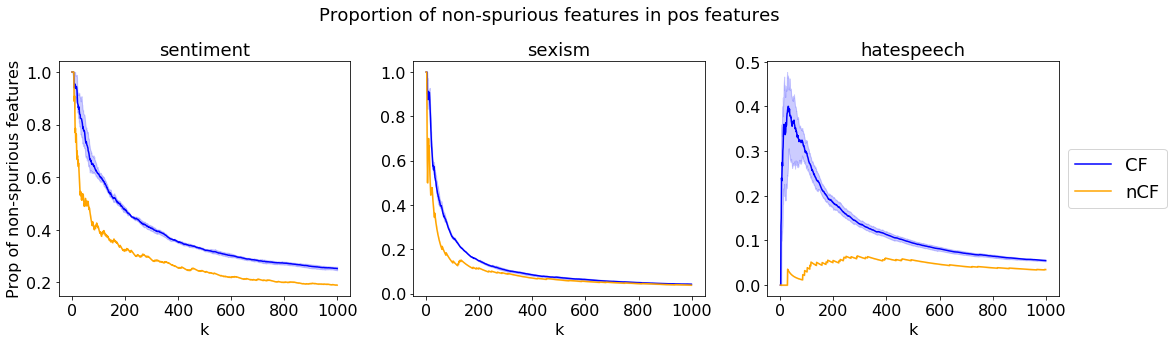

In [20]:
all_estimators = classifiers

top_k_feature_prop_combined(all_estimators, constructs = constructs, non_spuriouss = [(lexicons, "lexicons"),
                                                                                     # (out_domain_pivots, "pivot")
                                                                                     ])
# top_k_feature_prop_combined(all_estimators, constructs = constructs, which_type = 'neg', non_spuriouss = [(lexicons, "lexicons"),
#                                                                                       (out_domain_pivots, "pivot")])
# top_k_feature_prop(all_estimators, constructs = constructs, which_type = 'both')

### Significance Tests 

In [ ]:
# pickle that dict
import pickle 

# with open("../results/result_pkls/adversarial_results.pkl", 'wb+') as f:
#     pickle.dump(all_test_data, f)

# with open("../results/result_pkls/adversarial_results.pkl2", 'wb+') as f:
#     pickle.dump(all_test_data, f, protocol=2)
    
    
# read results dict


with open("../results/result_pkls/in_out_domain_results.pkl", 'rb') as handle:
    all_test_data = pickle.load(handle)
    
    
with open("../results/result_pkls/adversarial_results.pkl", 'rb') as handle:
    adv_test_data = pickle.load(handle)    

In [ ]:
len(all_test_data['sentiment']['logreg'])#, len(all_test_data['sexism']['logreg']), len(all_test_data['hatespeech']['logreg'])

In [ ]:
from utils import get_results
from sklearn.metrics import classification_report

In [ ]:
all_results = []

for construct in constructs:
    for mode in [False, True]:
        for model_name in models:
            for test_type in test_sets[construct]:                
                print()
                print(construct, model_name, mode, test_type)
                
                df = all_test_data[construct][model_name]
                df = df[df['dataset'] == test_type]
            
                cr = classification_report(df[construct], df["%s pred" %(mode)], output_dict = True)
                true = df[construct]
                pred = df["%s pred" %(mode)]
                
                #print(true, pred)
                all_results.append(get_results(cr, true, pred,
                                              method = model_name,
                                              mode = mode,
                                              construct = construct,     
                                              labels = {str(v): k for k, v in labels[construct].items()}, #invert label mapping
                                              dataset = test_type))

In [ ]:
results = {}
result_df = pd.DataFrame(all_results)
result_df['mode'] = result_df['mode'].map({True: "Counterfactual", False: "Non-Counterfactual"})
for construct in constructs:
    result_df_ = result_df[result_df['construct'] == construct]
    results[construct] = result_df_.groupby(['construct','method', 'dataset', 'mode'])[['Macro Average Precision', 'Macro Average Recall', 'Macro F1']].mean().unstack()                    
    
results['sentiment'].round(3)

In [ ]:
results['sexism'].round(3)

In [ ]:
results['hatespeech'].round(3)

In [ ]:
#! pip install statsmodels

In [ ]:
# Significance test on classifier results [https://machinelearningmastery.com/mcnemars-test-for-machine-learning/]

def mcnemars_test(data, dataset = 'all', construct = 'sexism',
                  model = 'logreg', alpha = 0.05):
    if dataset == 'all':
        data = data[construct][model]
    else:
        data = data[construct][model]
        data = data[data['dataset'] == dataset]
        
    table = pd.crosstab(data['True correct'],
            data['False correct'])
    
    #print(table)
    from statsmodels.stats.contingency_tables import mcnemar
    result = mcnemar(table, exact=False)

    print(construct, model, dataset)
    print('statistic=%.3f, p-value=%.4f' % (result.statistic, result.pvalue))
    
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')
    

    

In [ ]:
for construct in constructs:
    for model in ['bert']:
        for test_data in test_sets[construct]:
            mcnemars_test(all_test_data, test_data, construct, model)
            print("_______________________________________________________")
            print()
            print()
